In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Add ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
import openpyxl

In [7]:

# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define file paths for CSVs (Adjust if actual file names differ from what's inferred)
# Based on your outputs, these appear to be the actual sizes/min_soc in the files:
# 2019.1.21.xlsx - Sheet1.csv (2214 rows, Min SoC=18) - This HAS low SoC, so it's our TARGET TEST
# 2019.1.13.xlsx - Sheet1.csv (2705 rows, Min SoC=20) - This DOES NOT HAVE low SoC, so it's our BASE TRAIN

FILE_WITH_LOW_SOC = 'dataset/2019.1.21.xlsx'
FILE_WITHOUT_LOW_SOC = 'dataset/2019.1.13.xlsx'

# --- Data Loading and DEFINITIVE Train/Test Assignment ---
print("--- Loading Data and Assigning Train/Test Roles ---")
try:
    # Load the datasets based on their actual content/characteristics
    df_base_train = pd.read_excel(FILE_WITHOUT_LOW_SOC).dropna() # Larger dataset, no low SoC (original 'training')
    df_test_critical = pd.read_excel(FILE_WITH_LOW_SOC).dropna()  # Smaller dataset, HAS low SoC (original 'test')

    print(f"df_base_train (from '{os.path.basename(FILE_WITHOUT_LOW_SOC)}'): Shape={df_base_train.shape}, Min SoC={df_base_train['soc'].min()}")
    print(f"df_test_critical (from '{os.path.basename(FILE_WITH_LOW_SOC)}'): Shape={df_test_critical.shape}, Min SoC={df_test_critical['soc'].min()}")

    # Verify column consistency (crucial for concatenation)
    if not df_base_train.columns.equals(df_test_critical.columns):
        print("CRITICAL WARNING: Columns in df_base_train and df_test_critical are NOT identical!")
        print("df_base_train columns:", df_base_train.columns.tolist())
        print("df_test_critical columns:", df_test_critical.columns.tolist())
        # Attempt to align columns - this might drop some features if they don't match
        common_cols = list(set(df_base_train.columns) & set(df_test_critical.columns))
        df_base_train = df_base_train[common_cols]
        df_test_critical = df_test_critical[common_cols]
        print(f"Attempted to align columns. New shapes: {df_base_train.shape}, {df_test_critical.shape}")

except FileNotFoundError:
    print(f"Error: One or both CSV files not found. Creating dummy data mimicking ACTUAL load behavior.")
    # Dummy data that matches the shapes and min_soc found in the latest output
    def generate_dummy_data_actual_load(num_samples, start_mileage, min_soc_val):
        time_index = np.arange(num_samples)
        soc_initial = 100
        discharge_rate = 0.035 if min_soc_val >= 20 else 0.045
        soc = np.maximum(min_soc_val, soc_initial - time_index * discharge_rate + np.random.normal(0, 0.5, num_samples))
        voltage = 370 - (100 - soc) * 0.5 + np.random.normal(0, 0.5, num_samples)
        current = np.random.uniform(-50, 120, num_samples)
        speed = np.random.uniform(0, 100, num_samples)
        mileage = start_mileage + time_index * 0.05 + np.random.normal(0, 0.1, num_samples)
        
        start_time_str = "20190113000000" if num_samples == 2705 else "20190121000000"
        time_col = [str(int(start_time_str) + i * 10) for i in time_index] 
        
        df = pd.DataFrame({
            'time': time_col, 'speed': speed, 'mileage': mileage,
            'voltage': voltage, 'current': current, 'soc': soc
        })
        df['soc'] = df['soc'].astype(int)
        return df

    df_base_train = generate_dummy_data_actual_load(2705, 120560, min_soc_val=20) # This is the larger one, no low SoC
    df_test_critical = generate_dummy_data_actual_load(2214, 121900, min_soc_val=18) # This is the smaller one, HAS low SoC
    
    print(f"Dummy df_base_train: Shape={df_base_train.shape}, Min SoC={df_base_train['soc'].min()}")
    print(f"Dummy df_test_critical: Shape={df_test_critical.shape}, Min SoC={df_test_critical['soc'].min()}")


--- Loading Data and Assigning Train/Test Roles ---
df_base_train (from '2019.1.13.xlsx'): Shape=(2705, 6), Min SoC=20
df_test_critical (from '2019.1.21.xlsx'): Shape=(2214, 6), Min SoC=18


In [ ]:
# --- Strategic Data Augmentation for Training ---
# Take ALL data from df_test_critical (the one with low SoC) and ADD it to the training set
# This ensures the model learns the low-SoC behavior from real samples.
df_train_final = pd.concat([df_base_train, df_test_critical], ignore_index=True)

# The test set will now solely be df_test_critical. We will evaluate how well the model,
# trained with augmented low-SoC data, performs on the *entire* discharge curve that includes low SoC.
df_test_final = df_test_critical.copy() 

print(f"\nFinal Training Data Shape: {df_train_final.shape}, Min SoC: {df_train_final['soc'].min()}")
print(f"Final Test Data Shape: {df_test_final.shape}, Min SoC: {df_test_final['soc'].min()}")

# --- Feature Engineering ---
def apply_feature_engineering(df):
    # Convert 'time' to datetime if actual timestamps are needed, otherwise, just use as index
    # Given the string format, stick to using it as index for sorting.
    df = df.set_index('time', drop=False)
    df = df.sort_index() # Crucial for time-series operations to ensure order

    cols_for_engineering = ['speed', 'mileage', 'voltage', 'current', 'soc'] # 'soc' is included for its lagged versions

    # 1. Lagged Features: 1, 2, 3 steps back (increased to 3 for more context)
    for col in cols_for_engineering:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)
        df[f'{col}_lag3'] = df[col].shift(3) # New: Added lag 3
            
    # 2. Rate of Change (Derivative): 1 and 2 step differences
    for col in ['voltage', 'current', 'speed', 'mileage']:
        df[f'{col}_diff1'] = df[col].diff(1)
        df[f'{col}_diff2'] = df[col].diff(2) # New: Added 2-step difference
        
    # 3. Rolling Statistics (e.g., 5-step rolling mean/std)
    for col in ['voltage', 'current', 'speed', 'mileage']:
        df[f'{col}_roll_mean5'] = df[col].rolling(window=5, min_periods=1).mean() # min_periods for starting rows
        df[f'{col}_roll_std5'] = df[col].rolling(window=5, min_periods=1).std()
        df[f'{col}_roll_min5'] = df[col].rolling(window=5, min_periods=1).min() # New: Added roll min
        df[f'{col}_roll_max5'] = df[col].rolling(window=5, min_periods=1).max() # New: Added roll max

    # Drop any remaining NaN values that couldn't be filled (typically at the very beginning)
    df = df.dropna()
    return df

print("\n--- Applying Feature Engineering ---")
df_train_engineered = apply_feature_engineering(df_train_final.copy())
df_test_engineered = apply_feature_engineering(df_test_final.copy())

print(f"Engineered Final Train Data Shape: {df_train_engineered.shape}")
print(f"Engineered Final Test Data Shape: {df_test_engineered.shape}")
print("Sample of Engineered Final Train Data Head:\n", df_train_engineered.head())




Final Training Data Shape: (4919, 6), Min SoC: 18
Final Test Data Shape: (2214, 6), Min SoC: 18

--- Applying Feature Engineering ---
Engineered Final Train Data Shape: (4916, 45)
Engineered Final Test Data Shape: (2211, 45)
Sample of Engineered Final Train Data Head:
                           time  speed  mileage  voltage  current  soc  \
time                                                                    
20190113065044  20190113065044    5.4   120562    370.2      3.1  100   
20190113065054  20190113065054    0.0   120562    370.4      0.5  100   
20190113065104  20190113065104    0.0   120562    370.4      0.5  100   
20190113065114  20190113065114    0.0   120562    370.5      0.5  100   
20190113065124  20190113065124    0.0   120562    370.4      0.5  100   

                speed_lag1  speed_lag2  speed_lag3  mileage_lag1  ...  \
time                                                              ...   
20190113065044         6.5         0.0         0.0      120562.0  ...  

In [ ]:
# --- Prepare Features (X) and Target (y) ---
# Exclude original 'soc' and 'time' from features
FEATURES = [col for col in df_train_engineered.columns if col not in ['soc', 'time']]
TARGET = 'soc'

X_train_raw_fe = df_train_engineered[FEATURES]
y_train = df_train_engineered[TARGET]
X_test_raw_fe = df_test_engineered[FEATURES]
y_test = df_test_engineered[TARGET]

print(f"\nFeatures selected for training ({len(FEATURES)} features): {FEATURES[:7]}...") 
print(f"X_train_raw_fe shape: {X_train_raw_fe.shape}, y_train shape: {y_train.shape}")
print(f"X_test_raw_fe shape: {X_test_raw_fe.shape}, y_test shape: {y_test.shape}")


Features selected for training (43 features): ['speed', 'mileage', 'voltage', 'current', 'speed_lag1', 'speed_lag2', 'speed_lag3']...
X_train_raw_fe shape: (4916, 43), y_train shape: (4916,)
X_test_raw_fe shape: (2211, 43), y_test shape: (2211,)


In [ ]:

# --- Feature Scaling ---
print("\n--- Scaling Engineered Features ---")
scaler = StandardScaler()
X_train_scaled_fe = scaler.fit_transform(X_train_raw_fe)
X_test_scaled_fe = scaler.transform(X_test_raw_fe)

print("Scaling complete.")
print(f"X_train_scaled_fe shape: {X_train_scaled_fe.shape}")
print(f"X_test_scaled_fe shape: {X_test_scaled_fe.shape}")


--- Scaling Engineered Features ---
Scaling complete.
X_train_scaled_fe shape: (4916, 43)
X_test_scaled_fe shape: (2211, 43)


In [ ]:

# --- Time Series Sequencing (Sliding Window - Revised for longer context) ---
def create_sequences_revised(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

TIME_STEPS = 15 # Increased context window. Experiment with this (e.g., 5, 10, 20).

print(f"\n--- Creating Time Series Sequences with {TIME_STEPS} timesteps (Revised) ---")
X_train_seq, y_train_seq = create_sequences_revised(X_train_scaled_fe, y_train.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences_revised(X_test_scaled_fe, y_test.values, TIME_STEPS)



--- Creating Time Series Sequences with 15 timesteps (Revised) ---


In [ ]:
print(f"X_train_seq shape: {X_train_seq.shape} (samples, timesteps, features_per_timestep)")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape} (samples, timesteps, features_per_timestep)")
print(f"y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (4901, 15, 43) (samples, timesteps, features_per_timestep)
y_train_seq shape: (4901,)
X_test_seq shape: (2196, 15, 43) (samples, timesteps, features_per_timestep)
y_test_seq shape: (2196,)


In [ ]:

# --- Custom Weighted Loss Function ---
def weighted_mse_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    loss_per_sample = mse(y_true, y_pred)
    
    # Define parameters for weighting (tuned for low SoC)
    low_soc_threshold = 25.0 # Keep this aggressive, or tune to 20.0 if needed
    high_error_weight = 15.0 # Increased weight significantly. Try 10.0-30.0.
    
    low_soc_mask = tf.cast(tf.less_equal(y_true, low_soc_threshold), tf.float32)
    weighted_loss = loss_per_sample + (low_soc_mask * loss_per_sample * (high_error_weight - 1.0))
    
    return tf.reduce_mean(weighted_loss)


# --- Model Definitions (Adapted for new input shape) ---
def multi_head_attention_bigru(input_shape, learning_rate=0.0005): # Slightly reduced LR
    inputs = Input(shape=input_shape, name='bigru_input')
    bigru = tf.keras.layers.Bidirectional(GRU(32, return_sequences=True, name='bigru_layer'))(inputs) # Reduced units
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32, name='mha_layer')(bigru, bigru) # Reduced heads/key_dim
    attention_output = LayerNormalization(epsilon=1e-6, name='bigru_attention_norm')(attention_output + bigru)
    pooled_output = GlobalAveragePooling1D(name='bigru_global_avg_pooling')(attention_output)
    dense = Dense(32, activation='relu', name='bigru_dense_1')(pooled_output) # Reduced units
    dense = Dropout(0.5, name='bigru_dropout_1')(dense)
    outputs = Dense(1, name='bigru_output')(dense)
    model = Model(inputs, outputs, name='BiGRU_MHA_Model')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=weighted_mse_loss)
    return model

def time_series_transformer(input_shape, num_heads=4, key_dim=32, ff_dim=128, num_transformer_blocks=2, dropout_rate=0.4, learning_rate=0.0005): # Reduced complexity & increased dropout
    inputs = Input(shape=input_shape, name='transformer_input')
    embedding_layer = Dense(32, activation='relu', name='transformer_embedding')(inputs) # Reduced units
    x = embedding_layer
    for i in range(num_transformer_blocks):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, name=f'transformer_mha_{i}')(x, x)
        attention_output = Dropout(dropout_rate, name=f'transformer_mha_dropout_{i}')(attention_output)
        x = LayerNormalization(epsilon=1e-6, name=f'transformer_add_norm_1_{i}')(x + attention_output)
        ffn = Dense(ff_dim, activation='relu', name=f'transformer_ffn_1_{i}')(x)
        ffn = Dropout(dropout_rate, name=f'transformer_ffn_dropout_{i}')(ffn)
        ffn = Dense(embedding_layer.shape[-1], name=f'transformer_ffn_2_{i}')(ffn)
        x = LayerNormalization(epsilon=1e-6, name=f'transformer_add_norm_2_{i}')(x + ffn)
    x = GlobalAveragePooling1D(name='transformer_global_avg_pooling')(x)
    x = Dense(32, activation='relu', name='transformer_dense_1')(x) # Reduced units
    x = Dropout(dropout_rate, name='transformer_dropout_1')(x)
    outputs = Dense(1, name='transformer_output')(x)
    model = Model(inputs=inputs, outputs=outputs, name='TimeSeries_Transformer_Model')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=weighted_mse_loss)
    return model


In [ ]:

# --- Model Training and Prediction ---

model_input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

# Build the BiGRU model
bigru_model = multi_head_attention_bigru(model_input_shape)
print("\n--- BiGRU Model Summary ---")
bigru_model.summary()

# Define EarlyStopping callback (more patient, but will restore best weights)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6, verbose=1)



--- BiGRU Model Summary ---


2025-08-02 20:52:03.290013: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "BiGRU_MHA_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bigru_input (InputLayer)  │ (None, 15, 43)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 15, 64)         │         14,784 │ bigru_input[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mha_layer                 │ (None, 15, 64)         │         33,216 │ bidirectional[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 15, 64)         │              0 │ mha_layer[0][0],       │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bigru_attention_norm      │ (None, 15, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bigru_global_avg_pooling  │ (None, 64)             │              0 │ bigru_attention_norm[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bigru_dense_1 (Dense)     │ (None, 32)             │          2,080 │ bigru_global_avg_pool… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bigru_dropout_1 (Dropout) │ (None, 32)             │              0 │ bigru_dense_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bigru_output (Dense)      │ (None, 1)              │             33 │ bigru_dropout_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

print("\n--- Training BiGRU Model ---")
bigru_history = bigru_model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=64, verbose=1, 
                                 validation_split=0.1, callbacks=[early_stopping, reduce_lr])



--- Training BiGRU Model ---
Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 337.2601 - val_loss: 11.6533 - learning_rate: 6.2500e-05
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 354.5523 - val_loss: 18.3719 - learning_rate: 6.2500e-05
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 336.8935 - val_loss: 14.9422 - learning_rate: 6.2500e-05
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 331.4171 - val_loss: 12.9733 - learning_rate: 6.2500e-05
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 339.1548 - val_loss: 13.0443 - learning_rate: 6.2500e-05
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 365.6715 - val_loss: 14.0889 - learning_rate: 6.2500e-05
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 345.2453 - val_loss: 21.8715 - learning_rate: 6.2500e-05
Epoch 8/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 363.0365 - val_loss: 16.9064 - learning_rate: 6.2500e-05
Epoch 9/150
69/69 ━━━━━━━━━━━━━━━━

In [ ]:
# Predict using BiGRU
y_pred_bigru = bigru_model.predict(X_test_seq).flatten()

# Evaluate BiGRU (initial)
mse_bigru_initial = mean_squared_error(y_test_seq, y_pred_bigru)
mae_bigru_initial = mean_absolute_error(y_test_seq, y_pred_bigru)
rsq_bigru_initial = r2_score(y_test_seq, y_pred_bigru)
print(f"\nBiGRU Initial - MSE: {mse_bigru_initial:.4f}, MAE: {mae_bigru_initial:.4f}, RSQ: {rsq_bigru_initial:.4f}")

# Prepare error data for the Transformer
y_pred_bigru_train = bigru_model.predict(X_train_seq).flatten()
error_train = y_train_seq - y_pred_bigru_train

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

BiGRU Initial - MSE: 15.1799, MAE: 3.4518, RSQ: 0.9690
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


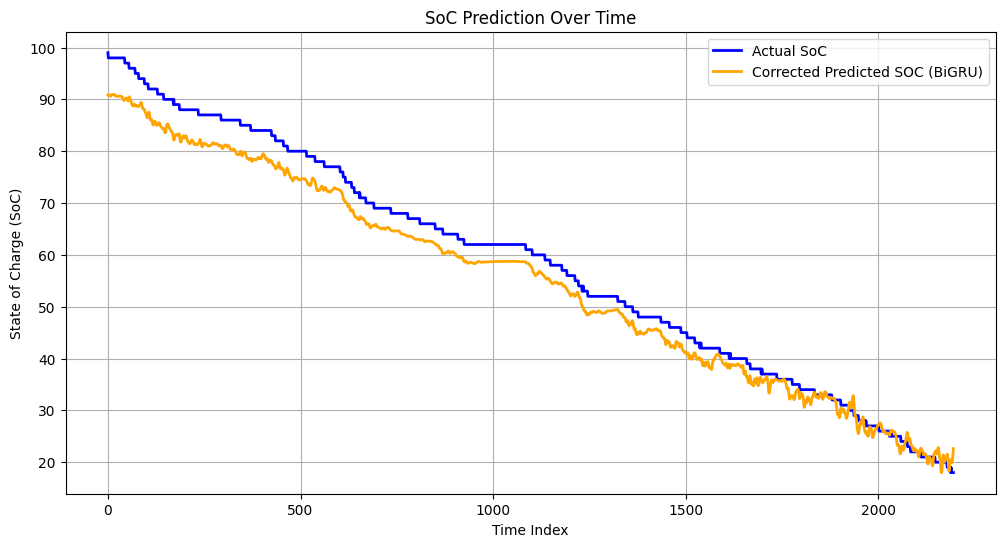

In [ ]:
# Plotting Smoothed SoC
min_len = min(len(y_pred_bigru), len(y_test_seq))
window_length = min(min_len - 1 if min_len % 2 == 0 else min_len, 11)
if window_length < 3:
    window_length = 3

smoothed_pred_bigru = savgol_filter(y_pred_bigru, window_length=window_length, polyorder=4)
# --- Plotting Results ---

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_seq)), y_test_seq, label='Actual SoC', color='blue', linewidth=2)
plt.plot(np.arange(len(smoothed_pred_bigru)), smoothed_pred_bigru, label='Corrected Predicted SOC (BiGRU)', color='orange', linewidth=2)
plt.xlabel("Time Index")
plt.ylabel("State of Charge (SoC)")
plt.title("SoC Prediction Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Build and train the Transformer model for error correction
transformer_model = time_series_transformer(model_input_shape)
print("\n--- Transformer Model Summary ---")
transformer_model.summary()

print("\n--- Training Transformer Model for Error Correction ---")
transformer_history = transformer_model.fit(X_train_seq, error_train, epochs=150, batch_size=64, verbose=1, 
                                            validation_split=0.1, callbacks=[early_stopping, reduce_lr])



--- Transformer Model Summary ---


Model: "TimeSeries_Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ transformer_input         │ (None, 15, 43)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_embedding     │ (None, 15, 32)         │          1,408 │ transformer_input[0][… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_mha_0         │ (None, 15, 32)         │         16,800 │ transformer_embedding… │
│ (MultiHeadAttention)      │                        │                │ transformer_embedding… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_mha_dropout_0 │ (None, 15, 32)         │              0 │ transformer_mha_0[0][… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 15, 32)         │              0 │ transformer_embedding… │
│                           │                        │                │ transformer_mha_dropo… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_add_norm_1_0  │ (None, 15, 32)         │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_ffn_1_0       │ (None, 15, 128)        │          4,224 │ transformer_add_norm_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_ffn_dropout_0 │ (None, 15, 128)        │              0 │ transformer_ffn_1_0[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_ffn_2_0       │ (None, 15, 32)         │          4,128 │ transformer_ffn_dropo… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 15, 32)         │              0 │ transformer_add_norm_… │
│                           │                        │                │ transformer_ffn_2_0[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_add_norm_2_0  │ (None, 15, 32)         │             64 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_mha_1         │ (None, 15, 32)         │         16,800 │ transformer_add_norm_… │
│ (MultiHeadAttention)      │                        │                │ transformer_add_norm_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_mha_dropout_1 │ (None, 15, 32)         │              0 │ transformer_mha_1[0][… │
│ (Dropout)                 │                        │                │                        │
├──────────────────────

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Transformer Model for Error Correction ---
Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 94.5641 - val_loss: 57.5871 - learning_rate: 5.0000e-04
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 28.3673 - val_loss: 59.6735 - learning_rate: 5.0000e-04
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 25.1387 - val_loss: 55.5376 - learning_rate: 5.0000e-04
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 23.4982 - val_loss: 63.2026 - learning_rate: 5.0000e-04
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 22.3695 - val_loss: 55.0191 - learning_rate: 5.0000e-04
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 22.2309 - val_loss: 61.5638 - learning_rate: 5.0000e-04
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 21.6039 - val_loss: 57.8581 - learning_rate: 5.0000e-04
Epoch 8/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 19.9681 - val_loss: 52.4799 - learning_rate: 5.0000e-04
Epoch 9/150
69

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


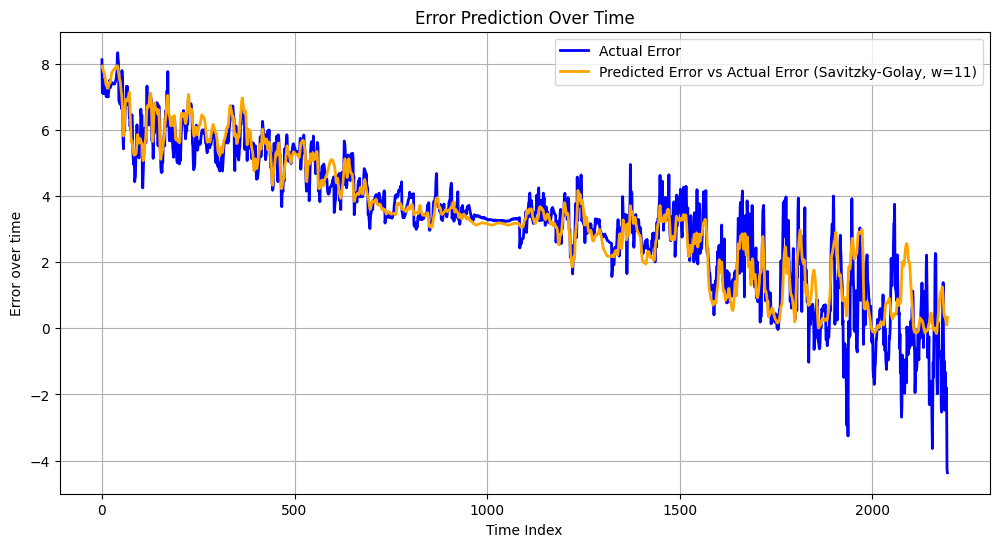

In [ ]:
error_train_seq = y_test_seq - y_pred_bigru

# Predict the error using the Transformer on the test set
predicted_error = transformer_model.predict(X_test_seq).flatten()

# Correct the BiGRU predictions
more_accurate_soc = y_pred_bigru + predicted_error

# Plotting Smoothed SoC
min_len = min(len(predicted_error), len(error_train_seq))
window_length = min(min_len - 1 if min_len % 2 == 0 else min_len, 11)
if window_length < 3:
    window_length = 3

smoothed_error = savgol_filter(predicted_error, window_length=window_length, polyorder=4)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(error_train_seq)), error_train_seq, label='Actual Error', color='blue', linewidth=2)
plt.plot(np.arange(len(smoothed_error)), smoothed_error, label=f'Predicted Error vs Actual Error (Savitzky-Golay, w={window_length})', color='orange', linewidth=2)
plt.xlabel("Time Index")
plt.ylabel("Error over time")
plt.title("Error Prediction Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


# --- Detailed Performance Comparison ---
print("\n" + "=" * 40)
print("             MODEL PERFORMANCE COMPARISON")
print("=" * 40)

print("BiGRU Model (Initial) Performance:")
print(f"  Mean Squared Error (MSE): {mse_bigru_initial:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_bigru_initial:.4f}")
print(f"  R-squared (R²): {rsq_bigru_initial:.4f}")
print("-" * 40)

# Evaluate the corrected SoC
mse_corrected = mean_squared_error(y_test_seq, more_accurate_soc)
mae_corrected = mean_absolute_error(y_test_seq, more_accurate_soc)
rsq_corrected = r2_score(y_test_seq, more_accurate_soc)

print("Corrected SoC (BiGRU + Transformer) Performance:")
print(f"  Mean Squared Error (MSE): {mse_corrected:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_corrected:.4f}")
print(f"  R-squared (R²): {rsq_corrected:.4f}")
print("-" * 40)

# Quantify the improvement due to error correction
improvement_mse = mse_bigru_initial - mse_corrected
improvement_mae = mae_bigru_initial - mae_corrected
improvement_rsq = rsq_corrected - rsq_bigru_initial

print("Improvement due to Error Correction:")
print(f"  Improvement in MSE: {improvement_mse:.4f}")
print(f"  Improvement in MAE: {improvement_mae:.4f}")
print(f"  Improvement in R-squared: {improvement_rsq:.4f}")

percentage_improvement_mse = (improvement_mse / mse_bigru_initial) * 100 if mse_bigru_initial != 0 else 0
percentage_improvement_mae = (improvement_mae / mae_bigru_initial) * 100 if mae_bigru_initial != 0 else 0

print("-" * 40)
print("Percentage Improvement due to Error Correction:")
print(f"  Percentage Improvement in MSE: {percentage_improvement_mse:.2f}%")
print(f"  Percentage Improvement in MAE: {percentage_improvement_mae:.2f}%")

errors_bigru = y_test_seq - y_pred_bigru
errors_corrected = y_test_seq - more_accurate_soc

print("-" * 40)
print("Error Analysis:")
print(f"  Standard Deviation of BiGRU Errors: {errors_bigru.std():.4f}")
print(f"  Standard Deviation of Corrected Errors: {errors_corrected.std():.4f}")
print(f"  Mean of BiGRU Errors: {errors_bigru.mean():.4f}")
print(f"  Mean of Corrected Errors: {errors_corrected.mean():.4f}")



             MODEL PERFORMANCE COMPARISON
BiGRU Model (Initial) Performance:
  Mean Squared Error (MSE): 15.1799
  Mean Absolute Error (MAE): 3.4518
  R-squared (R²): 0.9690
----------------------------------------
Corrected SoC (BiGRU + Transformer) Performance:
  Mean Squared Error (MSE): 0.5696
  Mean Absolute Error (MAE): 0.4802
  R-squared (R²): 0.9988
----------------------------------------
Improvement due to Error Correction:
  Improvement in MSE: 14.6103
  Improvement in MAE: 2.9716
  Improvement in R-squared: 0.0299
----------------------------------------
Percentage Improvement due to Error Correction:
  Percentage Improvement in MSE: 96.25%
  Percentage Improvement in MAE: 86.09%
----------------------------------------
Error Analysis:
  Standard Deviation of BiGRU Errors: 2.0711
  Standard Deviation of Corrected Errors: 0.7510
  Mean of BiGRU Errors: 3.3001
  Mean of Corrected Errors: -0.0752


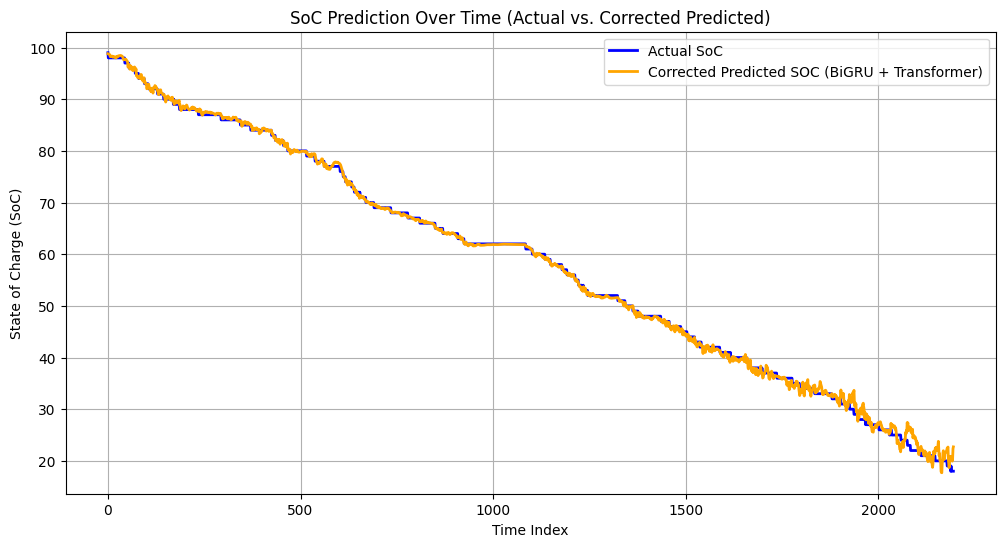

In [ ]:
# --- Plotting Results ---

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_seq)), y_test_seq, label='Actual SoC', color='blue', linewidth=2)
plt.plot(np.arange(len(more_accurate_soc)), more_accurate_soc, label='Corrected Predicted SOC (BiGRU + Transformer)', color='orange', linewidth=2)
plt.xlabel("Time Index")
plt.ylabel("State of Charge (SoC)")
plt.title("SoC Prediction Over Time (Actual vs. Corrected Predicted)")
plt.legend()
plt.grid(True)
plt.show()


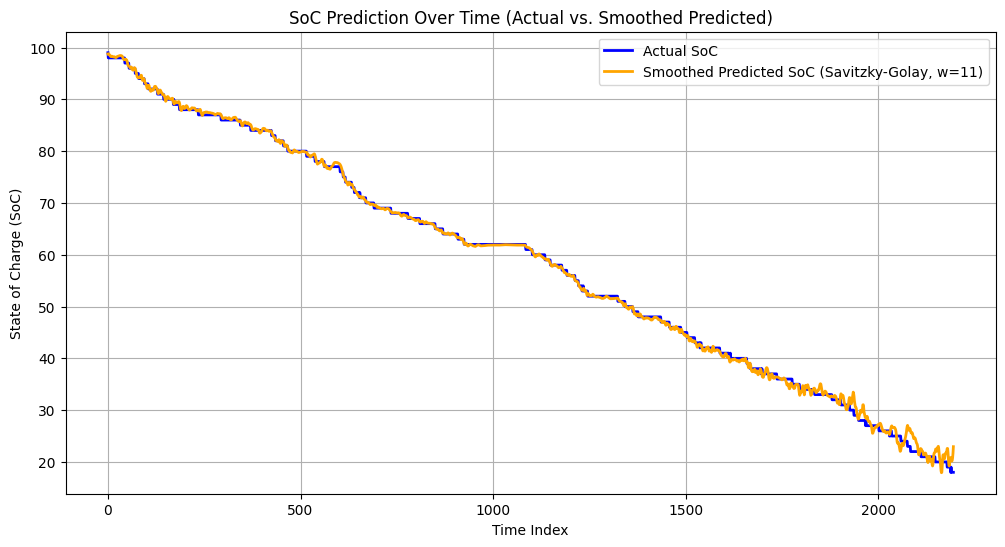

In [ ]:
# Plotting Smoothed SoC
min_len = min(len(more_accurate_soc), len(y_test_seq))
window_length = min(min_len - 1 if min_len % 2 == 0 else min_len, 11)
if window_length < 3:
    window_length = 3

smoothed_soc = savgol_filter(more_accurate_soc, window_length=window_length, polyorder=4)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_seq)), y_test_seq, label='Actual SoC', color='blue', linewidth=2)
plt.plot(np.arange(len(smoothed_soc)), smoothed_soc, label=f'Smoothed Predicted SoC (Savitzky-Golay, w={window_length})', color='orange', linewidth=2)
plt.xlabel("Time Index")
plt.ylabel("State of Charge (SoC)")
plt.title("SoC Prediction Over Time (Actual vs. Smoothed Predicted)")
plt.legend()
plt.grid(True)
plt.show()

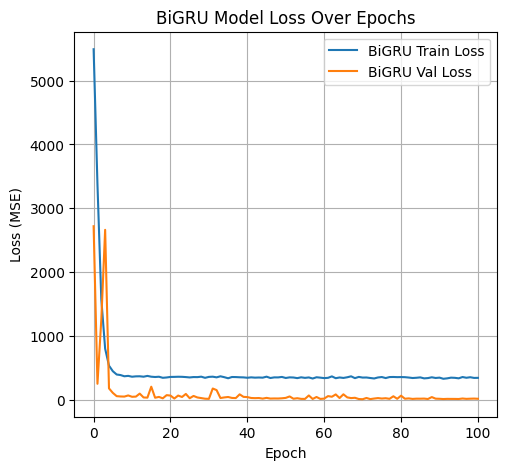

In [ ]:
# Plotting training/validation loss for both models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(bigru_history.history['loss'], label='BiGRU Train Loss')
if 'val_loss' in bigru_history.history:
    plt.plot(bigru_history.history['val_loss'], label='BiGRU Val Loss')
plt.title('BiGRU Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

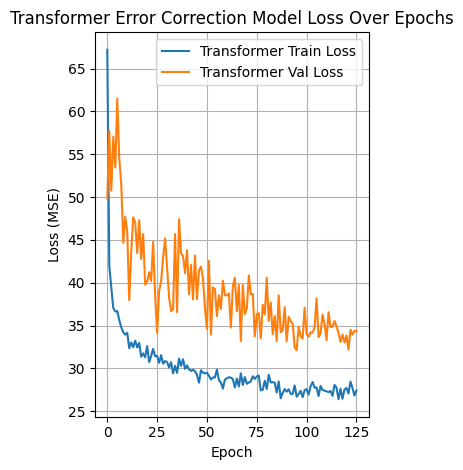

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(transformer_history.history['loss'], label='Transformer Train Loss')
if 'val_loss' in transformer_history.history:
    plt.plot(transformer_history.history['val_loss'], label='Transformer Val Loss')
plt.title('Transformer Error Correction Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()